## Data playground

In [2]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

### Testing transform on a target subreddit

In [3]:
# Load data
data = pd.read_json('../data/relationship_advice-m100.json')
data['distinguished'] = data['distinguished'].fillna(value='none')

**Basic idea**: Provided that a significant portion of score distributions are _heavily_ skewed towards low values, it is reasonable to claim most low-scoring comments are insignificant, and may be categorized the same. However, instead of choosing a random criteria (e.g. everything below 100 is insignificant), we aim to choose a more empirically consistent criteria.

To do this, we observe the nature of our data below...

count    45482.000000
mean        46.276241
std        416.994173
min       -824.000000
25%          1.000000
50%          2.000000
75%          7.000000
max      27179.000000
Name: score, dtype: float64

more percentiles:
75.000%: 7.000
80.000%: 11.000
90.000%: 41.000
95.000%: 111.000
97.500%: 269.975
99.000%: 828.000
99.900%: 5859.393
99.990%: 15465.673
99.999%: 24597.044


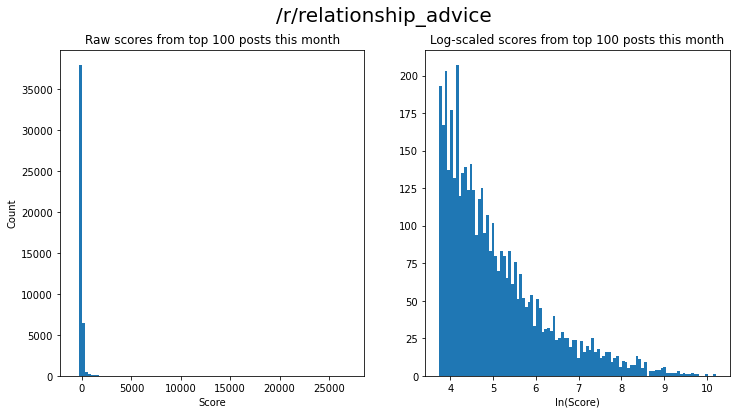

In [4]:
# basic info
print(data['score'].describe()); print()
print('more percentiles:')

percentiles = dict()
for i in (75, 80, 90, 95, 97.5, 99, 99.9, 99.99, 99.999):
    # store percentiles
    percentiles[i] = np.percentile(data['score'],i)
    print('{0:.3f}%: {1:.3f}'.format(i,percentiles[i]))

# take a look at score distribution...
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.hist(data['score'], 100)

# try stripping "insignificant" comments
data_stripped = list(filter(lambda x: x > percentiles[90], data['score']))
ax2.hist(np.log(data_stripped), 100)

plt.suptitle('/r/relationship_advice', fontsize=20)

ax1.set_title('Raw scores from top 100 posts this month')
ax2.set_title('Log-scaled scores from top 100 posts this month')

ax1.set(xlabel='Score', ylabel='Count')
ax2.set(xlabel='ln(Score)')

plt.show()

### Do all subreddits follow the same pattern?

As seen above, especially in the percentile breakdown, the vast majority of comments on _/r/Coronavirus_ have a very low score. Even without the breakdowns and graphs, one could just look at the quartiles, mean, and std. A good place to start to get a better understanding was truncating everything up to the 90th percentile (which could be a candidate "insignificant" categorical criterion) and performing a natural log-transform to see a better shape.

In [6]:
# subreddits to look at...
subreddits = [
    'askreddit', 
    'conservative',
    'funny', 
    'gaming', 
    'news', 
    'pics', 
    'politics', 
    'sandersforpresident', 
    'technology', 
    'worldnews'
]

# percentile cutoff
P = 90
data = list()

# get data for all
for sub in subreddits:
    # load
    try:
        d = pd.read_json('../data/{0}-m100.json'.format(sub))
    except:
        # something went wrong...
        continue
    d['distinguished'] = d['distinguished'].fillna(value='none')
    P_n = np.percentile(d['score'], P)
    # strip
    d_stripped = list(
        filter(
            # to pass, must be above P percentile
            lambda x: x > P_n,
            d['score']
        )
    )
    data.append(d_stripped)

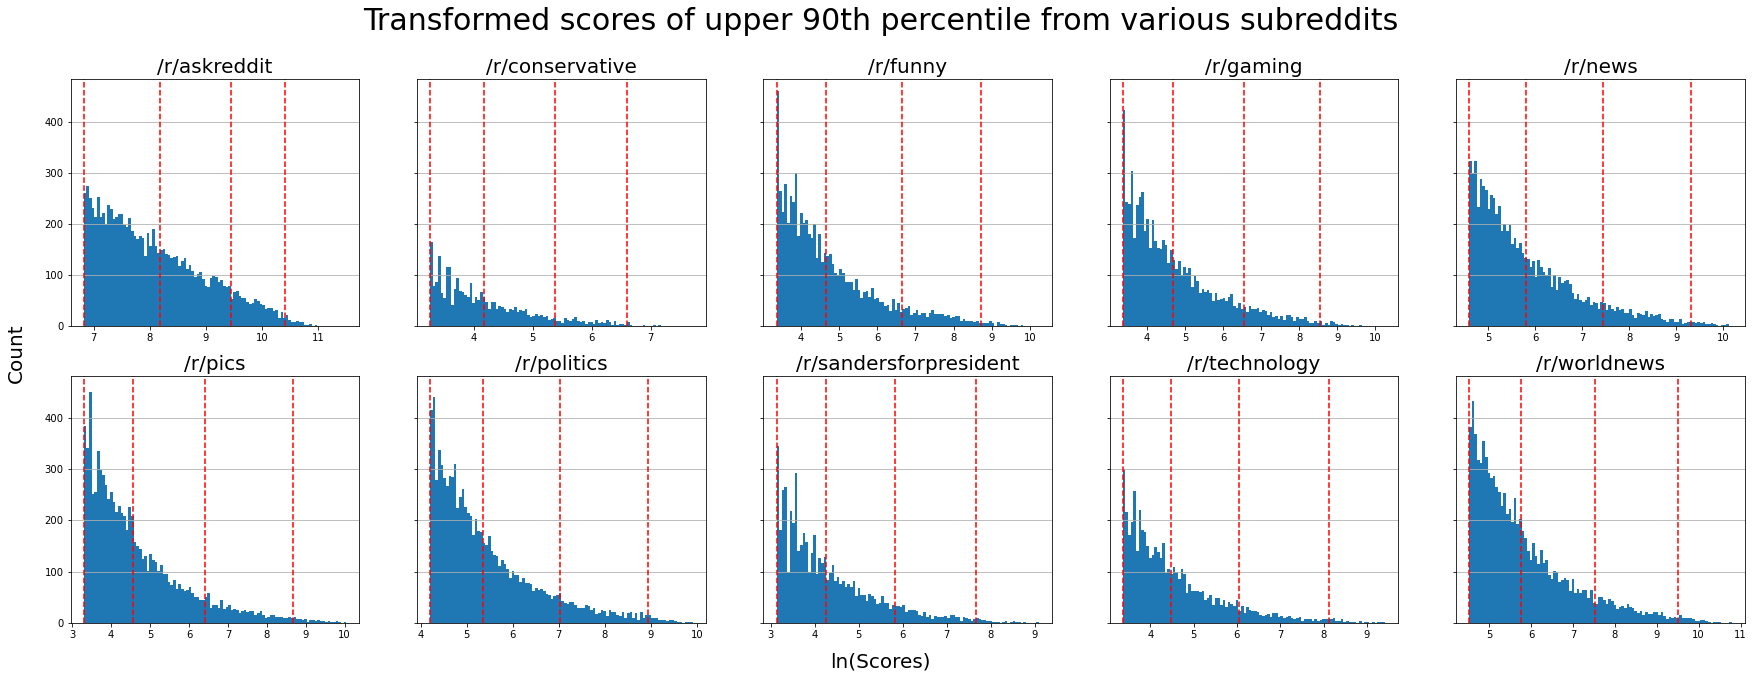

/r/askreddit
0.0th percentile:	917.00 upvotes
60.0th percentile:	3580.20 upvotes
90.0th percentile:	12767.00 upvotes
99.0th percentile:	33028.40 upvotes

/r/conservative
0.0th percentile:	26.00 upvotes
60.0th percentile:	65.00 upvotes
90.0th percentile:	216.00 upvotes
99.0th percentile:	735.45 upvotes

/r/funny
0.0th percentile:	29.00 upvotes
60.0th percentile:	107.00 upvotes
90.0th percentile:	761.70 upvotes
99.0th percentile:	6010.82 upvotes

/r/gaming
0.0th percentile:	29.00 upvotes
60.0th percentile:	109.00 upvotes
90.0th percentile:	706.00 upvotes
99.0th percentile:	5108.23 upvotes

/r/news
0.0th percentile:	99.00 upvotes
60.0th percentile:	329.00 upvotes
90.0th percentile:	1724.00 upvotes
99.0th percentile:	11128.47 upvotes

/r/pics
0.0th percentile:	27.00 upvotes
60.0th percentile:	96.00 upvotes
90.0th percentile:	610.80 upvotes
99.0th percentile:	5848.15 upvotes

/r/politics
0.0th percentile:	67.00 upvotes
60.0th percentile:	212.00 upvotes
90.0th percentile:	1120.00 upvotes
99.

In [7]:
# note that the 90th percentile is already omitted, as we truncated the data beforehand
categories = {
    'INSIGNIFICANT':  0.0,
    'SIGNIFICANT'  : 60.0, 
    'POPULAR'      : 90.0, 
    'VERY POPULAR' : 99.0
}

# plots (work with 10 subreddits)
fig, axs = plt.subplots(2, len(subreddits)//2, figsize=(30, 10), sharey=True)
i, bins = 0, 100
for r in range(axs.shape[0]):
    for c in range(axs.shape[1]):
        # natural log-transform
        d = np.log(data[i])
        axs[r,c].hist(d, bins)
        # set boundary lines
        for p in categories.values():
            axs[r,c].axvline(np.percentile(d, p), ls='--', color='r')
        axs[r,c].grid(axis='y')
        axs[r,c].set_title('/r/{0}'.format(subreddits[i]), fontsize=20)
        i += 1

fig.suptitle('Transformed scores of upper {0}th percentile from various subreddits'
             .format(P), fontsize=30)
fig.text(0.5, 0.07, 'ln(Scores)', ha='center', va='center', fontsize=20)
fig.text(0.1, 0.5, 'Count', ha='center', va='center', rotation='vertical', fontsize=20)
plt.show()

# show raw score boundaries (undo transformation)
for i in range(len(data)):
    print('/r/{0}'.format(subreddits[i]))
    for c in categories.values():
        print('{0}th percentile:\t{1:.2f} upvotes'.format(
            # get score of transformed percentile, undo transform
            c, np.exp(np.percentile(np.log(data[i]), c))
        ))
    print()


As shown above, it can be seen each subreddit can have its own _unique_ score distribution. This illustrates that for different models, it is ideal to have dynamic criteria for categorization of comment significance, provided that every subreddit exhibits its own distribution. It should be noted that the percentiles above are relative to the top 10 percent of scores + log-transform... meaning that the 0th percentile corresponds to the 90th percentile in the raw set, and 90th percentile corresponds to the 90th percentile of the ln(top 10 percent of scores).

**For a more formal definition:** 

$P_{n}(s)$: returns the $n$th percentile of set $s$. \
$d$:  all scores*. \
$D\leftarrow\{ln(d) \mid d > 0 \land d \geq P_{90}(d)\}$

_Insignificant_ : $\{d \mid d < P_{90}(d)\}$ \
_Notable_       : $\{d \mid d \in D \land P_{0}(D) \leq d < P_{60}(D) \}$ it should be noted: $P_{90}(d) = P_{0}(D)$ \
_Significant_   : $\{d \mid d \in D \land P_{60}(d) \leq d < P_{90}(D) \}$\
_Popular_       : $\{d \mid d \in D \land P_{90}(d) \leq d < P_{99.0}(D) \}$\
_Very Popular_  : $\{d \mid d \in D \land d \geq P_{99.0}(D) \}$

\* we always exclude scores at or below 0, as it means the community has deemed it not noteworthy.

In [8]:
# compute boundaries
def compute_bounds(data):
    res  = dict()
    P_90 = np.percentile(data,90)
    # excluding forall d <= 0
    log_data = np.log([d for d in data if d > P_90])
    res['INSIGNIFICANT'] = np.exp(np.percentile(log_data, 0)) # equivalent to np.percentile(data, 90)
    res['NOTABLE']       = np.exp(np.percentile(log_data, 60))
    res['SIGNIFICANT']   = np.exp(np.percentile(log_data, 90))
    res['POPULAR']       = np.exp(np.percentile(log_data, 99.0))
    # implicit 'VERY POPULAR'
    return res
    
# autocategorization
def categorize(d, bounds):
    # try all categories
    for cat, val in bounds.items():
        if d < val:
            return cat
    # if at this point, VERY POPULAR
    return 'VERY POPULAR'

Now that we have a strictly defined function for it provided only the dataset, categorization has suddenly become very modular. It may be applied through a basic lambda function along the target axis.

In [28]:
raw_data = pd.read_json('../data/askreddit-m100.json')

# simple example
bounds = compute_bounds(raw_data['score'])
raw_data['score_cat'] = raw_data['score'].apply(lambda x: categorize(x, bounds))

In [29]:
N = 15

# get a sneak-peek
print('upvotes\t|', 'category\t(first {0} values)'.format(N))
print('====================')
for i in range(N):
    print(raw_data['score'][i], '\t', raw_data['score_cat'][i])
print('...\t','...')
    
# see frequency of categories
print('\nfrequency\n====================')
print(raw_data['score_cat'].value_counts())
    
# criteria
print()
print('criteria\n====================')
for k, v in bounds.items():
    print(k,'\t< ',round(v,2))
print('VERY POPULAR', '\t>=', round(bounds['POPULAR'],2))

upvotes	| category	(first 15 values)
15678 	 POPULAR
647 	 INSIGNIFICANT
2653 	 NOTABLE
17742 	 POPULAR
7226 	 SIGNIFICANT
3757 	 SIGNIFICANT
44521 	 VERY POPULAR
15710 	 POPULAR
32448 	 POPULAR
5096 	 SIGNIFICANT
25848 	 POPULAR
512 	 INSIGNIFICANT
8212 	 SIGNIFICANT
986 	 NOTABLE
20218 	 POPULAR
...	 ...

frequency
INSIGNIFICANT    88709
NOTABLE           5912
SIGNIFICANT       2955
POPULAR            887
VERY POPULAR        99
Name: score_cat, dtype: int64

criteria
INSIGNIFICANT 	<  917.0
NOTABLE 	<  3580.2
SIGNIFICANT 	<  12767.0
POPULAR 	<  33028.4
VERY POPULAR 	>= 33028.4


Seeing some simple metrics above, one immediate concern could be the frequency chart. By definition, 90% of our data is confined to one category. This may pose as an issue, as hypothetically a model could guess `INSIGNIFICANT` every time, and attain a 90% accuracy... luckily it is pretty easy to test this out with a basic `DecisionTreeClassifier()` (see `research.ipynb`).

### Data cleaning and preprocessing

In [101]:
import afinn
from sklearn.model_selection import train_test_split

# reset for consistency
raw_data = pd.read_json('../data/askreddit-m100.json')

# clean + add some extra features
afinn_nlp = afinn.Afinn(language='en', emoticons=True)
raw_data['sentiment']  = raw_data['body'].apply(lambda text: afinn_nlp.score(text))
raw_data['word_count'] = raw_data['body'].apply(lambda text: len(text.split(' ')))
raw_data['char_count'] = raw_data['body'].apply(lambda text: len(text))
raw_data['distinguished'] = raw_data['distinguished'].fillna(value='none')

# use our new categorization technique
bounds = compute_bounds(raw_data['score'])
raw_data['score_cat']  = raw_data['score'].apply(lambda score: categorize(score, bounds))

In [35]:
# taking a look at our features (columns)
raw_data.columns

Index(['id', 'parent_id', 'top_level', 'depth', 'created_utc', 'time_dff',
       'body', 'score', 'gilds', 'distinguished', 'sentiment', 'word_count',
       'char_count', 'score_cat'],
      dtype='object')

### Metadata
Analyzing context of text requires a lot, so for our basic test model we are simply using the metadata as predictors.

In [36]:
# training data
train, test = train_test_split(raw_data, test_size=0.2)

# list columns to drop
cols_to_drop = ['id', 'parent_id', 'top_level', 'created_utc', 'body', 'score', 'score_cat']

# training data, drop misleading/irrelevant features
train_scores, train_meta = train['score_cat'], train.drop(columns=cols_to_drop)
test_scores , test_meta  = test['score_cat'] , test.drop(columns=cols_to_drop)

In [40]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# pipeline to scale and encode our data
features = raw_data.drop(columns=cols_to_drop)
full_pipeline = ColumnTransformer([
    ('num', StandardScaler(), list(features.select_dtypes(include=[np.number]))),
    ('cat', OneHotEncoder(), list(features.select_dtypes(include=[np.object]).columns))
])

# run through pipeline
x_meta = full_pipeline.fit_transform(train_meta)
x_test_meta = full_pipeline.transform(test_meta)

# just for clarity
y_meta = train_scores
y_test_meta = test_scores

In [66]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# fit our decision tree
dt_meta = DecisionTreeClassifier()
dt_meta = dt_meta.fit(x_meta, y_meta)

In [99]:
# evaluate
meta_predictions = dt_meta.predict(x_test_meta)

# scores
labels = list(set(raw_data['score_cat']))
accuracy  = accuracy_score(y_test_meta, meta_predictions)
precision = precision_score(y_test_meta, meta_predictions, labels=labels, average='weighted')
recall    = recall_score(y_test_meta, meta_predictions, labels=labels, average='weighted')
f1_score  = 2*precision*recall / (precision+recall)

In [69]:
# print scores
print('evaluation of DecisionTreeClassifier trained on metadata:')
print('accuracy  = {0:.5f}'.format(accuracy))
print('precision = {0:.5f}'.format(precision))
print('recall    = {0:.5f}'.format(recall))
print('F1 score  = {0:.5f}'.format(f1_score))

evaluation of DecisionTreeClassifier trained on metadata:
accuracy  = 0.83077
precision = 0.84143
recall    = 0.83077
F1 score  = 0.83606


In [98]:
# see frequency of categories
print('\nfrequency (actual)\n====================')
print(y_test_meta.value_counts())
print('\nfrequency (predicted)\n====================')
print(pd.Series(meta_predictions).value_counts())

# see feature importances
print('\nfeature importances\n====================')
feat_imp = dict(zip(train_meta.columns, dt_meta.feature_importances_))
for col in sorted(feat_imp, key=feat_imp.get, reverse=True):
    print(col.ljust(13), '\t', round(feat_imp[col],5))


frequency (actual)
INSIGNIFICANT    17764
NOTABLE           1162
SIGNIFICANT        598
POPULAR            172
VERY POPULAR        17
Name: score_cat, dtype: int64

frequency (predicted)
INSIGNIFICANT    17502
NOTABLE           1307
SIGNIFICANT        699
POPULAR            186
VERY POPULAR        19
dtype: int64

feature importances
time_dff      	 0.40906
word_count    	 0.23715
sentiment     	 0.14552
distinguished 	 0.12975
gilds         	 0.04865
depth         	 0.02987
char_count    	 0.0


The simple classifier works surprisingly well, despite the potential for underfitting. Interestingly, one immediate takeaway is that the time differential (between comment creation and post creation) has the highest significance for this dataset.

### Comment body text
Let's see what happens when we predict using the comment body as the prediction metric for score.

In [102]:
# training data
train, test = train_test_split(raw_data, test_size=0.2)

# training data, drop misleading/irrelevant features
train_scores, train_comm = train['score_cat'], train['body']
test_scores , test_comm  = test['score_cat'] , test['body']

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

# tf-idf vectorizer
term_freq = TfidfVectorizer(stop_words='english', sublinear_tf=True)

# transform
x_comments = term_freq.fit_transform(train_comm)
x_test_comments = term_freq.transform(test_comm)

# just for clarity
y_comments = train_scores
y_test_comments = test_scores

In [106]:
# train our DecisionTreeClassifier
dt_comm = DecisionTreeClassifier()
dt_comm = dt_comm.fit(x_comments, y_comments)

In [107]:
# evaluate
comm_predictions = dt_comm.predict(x_test_comments)

# scores
labels = list(set(raw_data['score_cat']))
accuracy  = accuracy_score(y_test_comments, comm_predictions)
precision = precision_score(y_test_comments, comm_predictions, labels=labels, average='weighted')
recall    = recall_score(y_test_comments, comm_predictions, labels=labels, average='weighted')
f1_score  = 2*precision*recall / (precision+recall)

In [109]:
# print scores
print('evaluation of DecisionTreeClassifier trained on comment data:')
print('accuracy  = {0:.5f}'.format(accuracy))
print('precision = {0:.5f}'.format(precision))
print('recall    = {0:.5f}'.format(recall))
print('F1 score  = {0:.5f}'.format(f1_score))

evaluation of DecisionTreeClassifier trained on comment data:
accuracy  = 0.84234
precision = 0.81872
recall    = 0.84234
F1 score  = 0.83036
